In [3]:
%matplotlib inline
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.optimize as spopt

import propagation

In [48]:
#tasks: 
#load data from mat file
#propagate
    
def make_interp_func(name, width, height):
     #load phase map data from file

    data = sio.loadmat(name + '.mat')
    data = data[name]
    (x_n, y_n) = np.shape(data)

    x = np.linspace(-width/2.0, width/2.0, x_n)
    y = np.linspace(-height/2.0, height/2.0, y_n)

    f = interpolate.interp2d(x, y, data, kind='linear', fill_value=0.)
    
    return np.vectorize(f)


def plot_function(function, x_list, y_list):
    X, Y = np.meshgrid(x_list, y_list, indexing='ij')
    
    data = function(X, Y)
    
    plt.pcolormesh(x_list, y_list, data)
    plt.show()

    
def plane_wave(k, angle, x_list, y_list):
    X, Y = np.meshgrid(x_list, y_list, indexing='ij')
    
    k_x = k*np.sin(angle)
    k_y = 0
    
    E = np.exp(1j*(k_x*X + k_y*Y))
    
    return E
    
def plot_fft(data, dx, dy):
    #shape of the input field
    n_x, n_y = data.shape

    #define spaxial frequency vectors
    k_x = np.fft.fftfreq(n=n_x, d=dx) *2*np.pi
    k_y = np.fft.fftfreq(n=n_y, d=dy) *2*np.pi    
    data_k = np.fft.fft2(data)
    
    k_x = np.fft.fftshift(k_x)
    k_y = np.fft.fftshift(k_y)
    data_k = np.fft.fftshift(data_k)
    
    return data_k, k_x, k_y
    

def phase_profile_lens(f, k, x_list, y_list):
    X, Y = np.meshgrid(x_list, y_list, indexing='ij')
    phase = k*np.sqrt(X**2 + Y**2 + f**2)
    return np.exp(-1j*phase)
    
def phase_profile_mirror(f, k, x_list, y_list):
    X, Y = np.meshgrid(x_list, y_list, indexing='ij')
    phase = k*np.sqrt(f**2 + 4*(X**2 + Y**2))
    return np.exp(1j*phase)

    
def simulate_retroreflector(angle, log):
    wavelength = 1.55
    refractive_index = 1.53
    k = 2*np.pi/wavelength*refractive_index
    size = 120
    dx = dy = pixel_size = 0.7
    seperation = 150
    
    
    x_list = y_list = np.arange(-size/2., size/2., pixel_size)
    X, Y = np.meshgrid(x_list, y_list, indexing='ij')
    z_list = np.linspace(0, seperation, 80)
    
    ms1_size = 120.
    ms1_name = 'MS_phase_1'
    ms1_function = make_interp_func(ms1_name, ms1_size, ms1_size)
    #ms1_field = 1*np.exp(1j*ms1_function(X, Y)*2*np.pi)
    #ms1_field = 1+0*X
    ms1_field = phase_profile_lens(f=seperation, k=k, x_list=x_list, y_list=y_list)
    ms1_field[X**2 + Y**2 > (ms1_size/2.)**2] = 0.
    
    ms2_size = 100.
    ms2_name = 'MS_phase_2'
    ms2_function = make_interp_func(ms2_name, ms2_size, ms2_size)
    #ms2_field = 1*np.exp(1j*ms2_function(X, Y)*2*np.pi)
    #ms2_field = 1+0*X
    ms2_field = phase_profile_mirror(f=2*seperation, k=k, x_list=x_list, y_list=y_list)
    ms2_field[X**2 + Y**2 > (ms2_size/2.*0.95)**2] = 0.
    
    
    if 0:
        f, axes = plt.subplots(1, 2, figsize=(14, 5))

        im = axes[0].pcolormesh(x_list, y_list, np.angle(ms1_field))
        f.colorbar(im, ax=axes[0])
        axes[0].set_title('MS1 Phase profile')
        axes[0].set_xlabel('x (um)')
        axes[0].set_ylabel('y (um)')
        axes[0].set_aspect('equal', 'box')

        im = axes[1].pcolormesh(x_list, y_list, np.angle(ms2_field))
        f.colorbar(im, ax=axes[1])
        axes[1].set_title('MS2 Phase profile')
        axes[1].set_xlabel('x (um)')
        axes[1].set_ylabel('y (um)')
        axes[1].set_aspect('equal', 'box')

    
    #propagate fields
    incident_wave = plane_wave(k=k, angle=angle, x_list=x_list, y_list=y_list)
    after_ms1_field = ms1_field*incident_wave
    forward_propagation = propagation.propagate_angular_padded(field=after_ms1_field, k=k, z_list=z_list, dx=dx, dy=dy)
    after_ms2_field = forward_propagation[:, :, -1]*ms2_field
    reverse_propagation = propagation.propagate_angular_padded(field=after_ms2_field, k=k, z_list=z_list, dx=dx, dy=dy)
    after_ms1_field_prop = reverse_propagation[:, :, -1]*ms1_field
    
    
    #Plots
    vmin = None if log else 0
    n = 5
    #axes = [None]*n
    f, axes = plt.subplots(1, n, figsize=(6*n, 5))
    
    
    axis = 0
    #f, axes[axis] = plt.subplots(1, 1)
    data_k, k_x, k_y = plot_fft(data=incident_wave, dx=dx, dy=dy)
    image = np.abs(data_k)**2
    im = axes[axis].pcolormesh(k_x, k_y, image, vmin=0)
    f.colorbar(im, ax=axes[axis])
    axes[axis].set_title('Device Incident Wave (K-space)')
    axes[axis].set_xlabel("k_x (1/um)")
    axes[axis].set_ylabel("k_y (1/um)")
    
    
#     axis = 1
#     f, axes[axis] = plt.subplots(1, 1)
#     image = np.real(incident_wave)
#     im = axes[axis].pcolormesh(x_list, y_list, image, vmin=0)
#     f.colorbar(im, ax=axes[axis])
#     axes[1].set_title('Re{E} of incident beam')
#     axes[axis].set_xlabel("x (um)")
#     axes[axis].set_ylabel("y (um)")
       
    
    axis = 1
    #f, axes[axis] = plt.subplots(1, 1)
    image = np.abs(forward_propagation[:, int(len(y_list)/2), :])**2
    if log: image = np.log(image)
    im = axes[axis].contourf(z_list, x_list, image, vmin=vmin)
    f.colorbar(im, ax=axes[axis])
    axes[axis].set_title('Cross-section of reverse propagation |E|^2')
    axes[axis].set_xlabel("z (um)")
    axes[axis].set_ylabel("y (um)")

#     #plot as seperate figure
#     f_cross, axis_cross = plt.subplots(1, 1)
#     stitched_field = forward_propagation[:, int(len(y_list)/2), :]
#     stitched_z_list = z_list
#     image = np.abs(stitched_field)**2
#     if log: image = np.log(image)
#     im = axis_cross.contourf(z_list, x_list, image, vmin=vmin)
#     f_cross.colorbar(im, ax=axis_cross)
#     axis_cross.set_title('Cross-section of forward propagation |E|^2')
#     axis_cross.set_xlabel("z (um)")
#     axis_cross.set_ylabel("y (um)")
    
#     #plot as seperate figure
#     f_cross, axis_cross = plt.subplots(1, 1)
#     stitched_field = reverse_propagation[:, int(len(y_list)/2), :]
#     image = np.abs(stitched_field)**2
#     if log: image = np.log(image)
#     im = axis_cross.contourf(z_list, x_list, image, vmin=vmin)
#     f_cross.colorbar(im, ax=axis_cross)
#     axis_cross.set_title('Cross-section of reverse propagation |E|^2')
#     axis_cross.set_xlabel("z (um)")
#     axis_cross.set_ylabel("y (um)")
    
    
    axis = 2
    #f, axes[axis] = plt.subplots(1, 1)
    image = np.abs(after_ms2_field)**2
    if log: image = np.log(image)
    im = axes[axis].pcolormesh(x_list, y_list, image, vmin=vmin)
    f.colorbar(im, ax=axes[axis])
    axes[axis].set_title('Reflection Plane (|E|^2)')
    axes[axis].set_xlabel("x (um)")
    axes[axis].set_ylabel("y (um)")
    
    axis = 3
    #f, axes[axis] = plt.subplots(1, 1)
    image = np.abs(reverse_propagation[:, int(len(y_list)/2), :])**2
    if log: image = np.log(image)
    im = axes[axis].contourf(z_list, x_list, image, vmin=vmin)
    f.colorbar(im, ax=axes[axis])
    axes[axis].set_title('Cross-section of reverse propagation |E|^2')
    axes[axis].set_xlabel("z (um)")
    axes[axis].set_ylabel("y (um)")

#     axis = 5
#     f, axes[axis] = plt.subplots(1, 1)
#     image = np.real(after_ms1_field_prop)
#     if log: image = np.log(image)
#     im = axes[axis].pcolormesh(x_list, y_list, image, vmin=vmin)
#     f.colorbar(im, ax=axes[axis])
#     axes[axis].set_title('Final Field Re{E}')
#     axes[axis].set_xlabel("x (um)")
#     axes[axis].set_ylabel("y (um)")
    
    axis = 4
    #f, axes[axis] = plt.subplots(1, 1)
    data_k, k_x, k_y = plot_fft(data=after_ms1_field_prop, dx=dx, dy=dy)
    image = np.abs(data_k)**2
    im = axes[axis].pcolormesh(k_x, k_y, image)
    f.colorbar(im, ax=axes[axis])
    axes[axis].set_title('Device Reflection (K-space)')
    axes[axis].set_xlabel("k_x (1/um)")
    axes[axis].set_ylabel("k_y (1/um)")

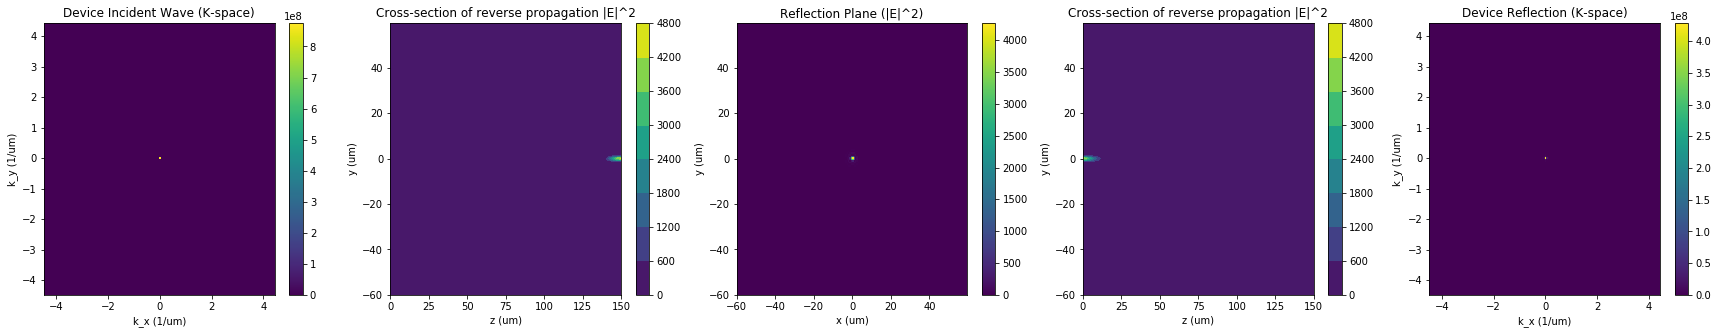

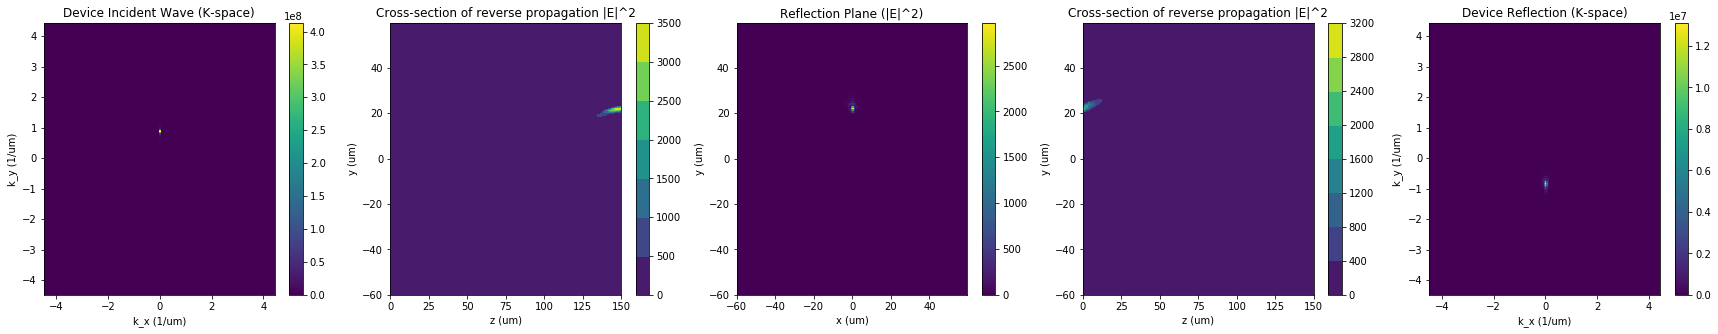

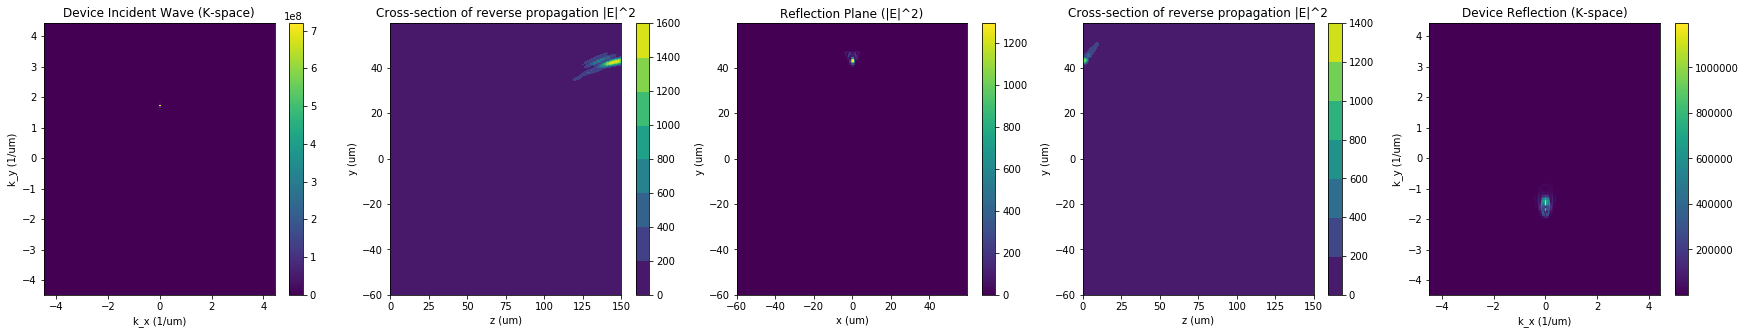

In [49]:
[simulate_retroreflector(angle=angle*np.pi/180, log=False) for angle in np.linspace(0, 16, 3)];

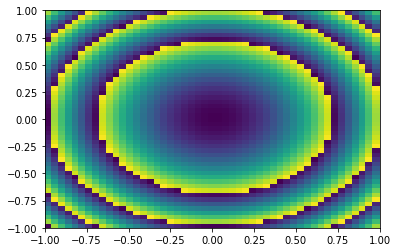

[0.24073303 0.23073719 0.2240733  0.22074136 0.22074136 0.2240733
 0.23073719 0.24073303 0.23406914 0.21740941 0.20408163 0.1940858
 0.18742191 0.18408996 0.18408996 0.18742191 0.1940858  0.20408163
 0.21740941 0.23406914 0.24406497 0.22074136 0.20074969 0.18408996
 0.17076218 0.16076635 0.15410246 0.15077051 0.15077051 0.15410246
 0.16076635 0.17076218 0.18408996 0.20074969 0.22074136 0.24406497
 0.24073303 0.21407747 0.19075385 0.17076218 0.15410246 0.14077468
 0.13077884 0.12411495 0.12078301 0.12078301 0.12411495 0.13077884
 0.14077468 0.15410246 0.17076218 0.19075385 0.21407747 0.24073303
 0.24406497 0.21407747 0.18742191 0.16409829 0.14410662 0.1274469
 0.11411912 0.10412328 0.09745939 0.09412745 0.09412745 0.09745939
 0.10412328 0.11411912 0.1274469  0.14410662 0.16409829 0.18742191
 0.21407747 0.24406497 0.22074136 0.19075385 0.16409829 0.14077468
 0.12078301 0.10412328 0.0907955  0.08079967 0.07413578 0.07080383
 0.07080383 0.07413578 0.08079967 0.0907955  0.10412328 0.1207830

In [40]:
n = 50
x = y = np.linspace(-1, 1, n)

X, Y = np.meshgrid(x, y, indexing='ij')

data = (X**2 + Y**2)%0.5

plt.pcolormesh(x, y, data)
plt.show()

print(data[X**2+Y**2 < 0.5**2])

